<span style="font-family:Papyrus; font-size:3em;">BIOE 498 Midterm</span>

<span style="font-family:Papyrus; font-size:2em;">Design of Experiments</span>

# Problem

BioModels model 45 shows bursting behavior of Calcium oscillations using the chemical species ``EC``, ``X``, ``Y``, and ``Z``.
Factors affecting the Ca oscillations include the initial concentrations of these four chemical species.
In this problem, you will find levels of these factors such that:
1. ``Y`` has oscillations of at least 1.5 Hz during the times 5 sec to 30 sec.
1. The "amplitude" (Fourier coefficient) for the oscillations is at least 2.5.
1. All concentrations of the chemical species are non-negative in the simulation.

There are three parts to answering this question.

1. (10 pts) **Design of Experiments**. What is your experimental design? That is: (a) what is the baseline; (b) what are the factors; (c) what are the levels of the factors; and (d) what $n$WD did you use.
Explain why you chose the particular levels and $n$. It may be that you use a "mixed" strategy in which you
do initial experiments with one design, and based on these outcomes, you do a new design.

1. (30 pts) **Experimental Infrastructure**. Implement the following functions.
As always, you should have documentation and tests for each function.
Note that BioModels 45 is the file ``BIOMD0000000045_url.xml`` in the ``common`` directory. (See code below.)

   1. ``runExperiment`` runs an experiment for levels of initial values of chemical species and returns
   the result of the simulation. The function optionally
   plots the results. 
   1. ``getResponse`` calculates the the
   values of the frequency with the largest amplitude (along with the amplitude) for a chemical species over a
   designated time interval.
   1. ``runStudy`` runs a set of experiments, checking for combinations of factor levels that match the
   objectives of this study.
    
1. (10 pts) **Studies and Analysis**. Describe the studies you conducted, showing how you found a combination of factor levels that meet the requirements.

Please put your answers to these questions in the separate sections below.

# Programming Preliminaries
This section provides the setup to run your python codes.

In [1]:
IS_COLAB = False
#
if IS_COLAB:
  !pip install matplotlib
  !pip install numpy
  !pip install tellurium
  !pip install SBstoat
#    
# Constants for standalone notebook
if not IS_COLAB:
    COMMON_DIR = "/home/ubuntu/advancing-biomedical-models/common"
else:
    from google.colab import drive
    drive.mount('/content/drive')
    COMMON_DIR = "/content/drive/MyDrive/Winter 2021/common"
import sys
sys.path.insert(0, COMMON_DIR)

In [2]:
import util_doe1  # Various functions from lecture 5
import util_doe2  # Various functions from lecture 6

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from SBstoat.namedTimeseries import NamedTimeseries
import tellurium as te

# Model

In [3]:
modelPath = os.path.join(COMMON_DIR, "BIOMD0000000045_url.xml")
ROADRUNNER = te.loads(modelPath)
print(ROADRUNNER.getAntimony())

// Created by libAntimony v2.12.0
model *Goldbeter_Calcium_Oscillation_based_onCICR_AND_two_pool_model()

  // Compartments and Species:
  compartment extracellular, cytosol, intravesicular1, intravesicular2;
  species EC in extracellular, Z in cytosol, Y in intravesicular2, X in intravesicular1;

  // Reactions:
  vin: EC => Z; cytosol*(vin_v0 + vin_v1*beta);
  v2i: Z => Y; intravesicular2*v2i_Vm2i*Z^2/(v2i_K2i^2 + Z^2);
  v3i: Y => Z; cytosol*v3i_Vm3i*Y^2*Z^2/((v3i_K3y^2 + Y^2)*(v3i_K3z^2 + Z^2));
  v4: Y => Z; cytosol*v4_Kf*Y;
  v5: Z => EC; extracellular*v5_K*Z;
  v6: X => Z; cytosol*v6_Kf*X;
  v2s: Z => X; intravesicular1*v2s_Vm2s*Z^2/(v2s_K2s^2 + Z^2);
  v3s: X => Z; cytosol*beta*v3s_Vm3s*X^2/(v3s_K3s^2 + X^2);

  // Species initializations:
  EC = 0;
  Z = 0;
  Y = 0;
  X = 0.5;

  // Compartment initializations:
  extracellular = 1;
  cytosol = 1;
  intravesicular1 = 1;
  intravesicular2 = 1;

  // Variable initializations:
  beta = 1;
  vin_v0 = 0.015;
  vin_v1 = 0.012;
  v2i_

In [4]:
# Simulation constants
START_TIME = 0  # Start time for the simulation
END_TIME = 60  # End time for the simulation
BURST_DCT = {0: (15, 25), 1: (40, 50)}  # Where bursts should be preserved
NUM_POINT = 10*(END_TIME - START_TIME)  # Number of points in output
PARAMETERS = ["X", "Y", "Z", "EC"]
TIME = "time"

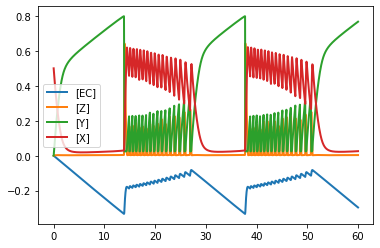

In [5]:
ROADRUNNER.plot(ROADRUNNER.simulate(0,60, 1200))

# Experimental Design

The experimental design will initially use one factor at a time (1WD) because the combinatorics
are modest.
If this fails, we'll use two factors in combination (2WD).

# Experimental Infrastructure

In [76]:
def runExperiment(parameterDct, isPlot=True, startTime=5, endTime=30):
    """
    """
    ROADRUNNER.reset()
    for parameter, value in parameterDct.items():
        ROADRUNNER[parameter] = value
    data = ROADRUNNER.simulate(START_TIME, END_TIME, NUM_POINT)
    maxY = max(data["[Y]"])
    #
    figure, ax = plt.subplots(1)
    title = " ".join(["%s: %1.2f" % (k, v) for k, v in parameterDct.items()])
    for col in data.colnames[1:]:
        _ = ax.plot(data[TIME], data[col])
    _ = ax.set_title(title)
    _ = ax.set_xlim([startTime, endTime])
    _ = plt.legend(data.colnames[1:])
    #ROADRUNNER.plot(data, title=title, ax=ax)
    if not isPlot:
        _ = plt.close()
    return data

# Test
data = runExperiment({"X": 0, "Y": 1}, isPlot=False)
assert(len(data) > 0)
print("OK!")

OK!


In [54]:
def getResponse(molecule, data, startTime=5, endTime=30):
    """
    Calculates the fourier coefficient for the highest amplitude frequency in the specified interval.

    Parameters
    ----------
    data: NamedArray/pd.DataFrame
    startTime: float
    endTime: float

    Returns
    -------
    float, float: frequency, amplitude
    """
    def findIndex(time, times):
        return sum([v <= time for v in times])
    # 
    MIN_TIME_OFFSET = 5
    if isinstance(data, pd.DataFrame):
        dataTS = NamedTimeseries(dataframe=data)
    else:
        dataTS = NamedTimeseries(namedArray=data)
    times = dataTS[TIME]
    startIndex = findIndex(startTime, times)
    endIndex = findIndex(endTime, times)
    newData = dataTS[startIndex:endIndex]
    freq, ampl = util_doe1.getFrequencyAmplitude(molecule, newData, offset=0)
    return freq, ampl
        
# TESTS
parameterDct = {"EC": 0.5, "X": 0, "Y": 1}
startTime, endTime = 5, 30
data = runExperiment(parameterDct, startTime=startTime, endTime=endTime, isPlot=False)
result = getResponse("Y", data, startTime, endTime)
assert(result[0] > 1)
print("OK!")

OK!


In [86]:
def runStudy(levels=[0.1*v for v in range(11)], isProgressReport=True, isTFC=True):
    """
    Runs experiments searching for combinations of parameter values that statisfy:
    1. ``Y`` has oscillations of at least 1.5 Hz during the times 5 sec to 30 sec.
    2. The "amplitude" (Fourier coefficient) for the oscillations is at least 2.5.
    3. All concentrations of the chemical species are non-negative in the simulation.
    
    Parameters
    ----------
    levels: list-float
        levels to use for initial values of chemical species
    isProgressReport: bool
        reports initial values of parameters being tested
    isTFC: bool
        two factor in combination design
        
    Returns
    -------
    int: number of experiments run
    """
    # One factor at a time study
    numExperiment = 0
    AMPLITUDE_MIN = 2.5
    FREQUENCY_MIN = 1.5
    done = False
    parameterItr = itertools.product(PARAMETERS, PARAMETERS)
    for parameter1, parameter2 in parameterItr:
        if parameter1 == parameter2:
            continue
        if done:
            break
        levelItr = itertools.product(levels, levels)
        for level1, level2 in levelItr:
            parameterDct = {parameter1: level1}
            if isTFC:
                parameterDct[parameter2] = level2
            data = runExperiment(parameterDct, isPlot=False)
            for col in data.colnames:
                trues = [v >= 0 for v in data[col]]
                if not all(trues):
                    continue
            numExperiment += 1
            freq, ampl = getResponse("Y", data)
            if isProgressReport:
                print("%s: %2.1f, %s: %2.1f" % (parameter1, level1, parameter2, level2))
            if (ampl >= AMPLITUDE_MIN) and (freq >= FREQUENCY_MIN):
                _ = runExperiment(parameterDct, isPlot=True)
                done = True
                break
    return numExperiment
                
# Tests
numExperiment = runStudy(levels=[0, 0.5], isProgressReport=False)
assert(numExperiment == 6*4*2)
print("OK!")

OK!


# Studies and Analysis

By choosing a combination of factors at the low and high end of change, the combinatorics were modest.
Changes two factors in combination was sufficient to find a combination of values
that met the requirements of the problem.

In [87]:
runStudy(levels=[0.1, 0.2, .9, 1], isProgressReport=False, isTFC=False)

192

Since we failed to find a combination of levels that meets our criteria, we now use TFC.

19

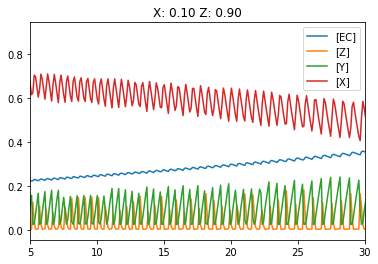

In [88]:
runStudy(levels=[0.1, 0.2, .9, 1], isProgressReport=False, isTFC=True)

We found values that meet our requirements, including that all concentrations are non-negative.